In [1]:
import os
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

### Initialise the environment

In [2]:
p1 = 0.75 # true expected payoff for arm 1
p2 = 0.50 # true expected payoff for arm 2

arms = [p1, p2]

### Initialise the agent

In [3]:
def policy(q_values, temp=None):

    if temp:
        t = temp
    else:
        t = 1
    return np.exp(q_values*t)/np.sum(np.exp(q_values*t))

def belief_update(M_curr, arm, rew):

    M_next = M_curr.copy()
    if rew == 1:
        M_next[arm, 0] += 1
    else:
        M_next[arm, 1] += 1
    return M_next

gamma   = 0.9
gittins = np.genfromtxt('../gittins200_gamma09.csv', delimiter=',') # load gittins indices
gittins = gittins[1:, 1:] # remove (0, .) and (., 0) priors

# initial belief state
M = np.array([
    [1, 1],
    [1, 1]
], dtype=int)

temp = 8 # inverse temperature for softmax

### Run the model-free agent

In [4]:
np.random.seed(1234)

num_episodes = 180
for ep in range(num_episodes):
    Q  = np.array([gittins[M[0, 0], M[0, 1]], gittins[M[1, 0], M[1, 1]]])
    # a = np.argmax(Q)
    ps = policy(Q, temp=temp)
    a  = np.random.choice([0, 1], p=ps)
    r  = np.random.choice([0, 1], p=(1-arms[a], arms[a]))
    M  = belief_update(M, a, r)

### Plot the resulting belief

Text(0.5, 1.0, '$\\mathbb{E}[p\\mid b]$')

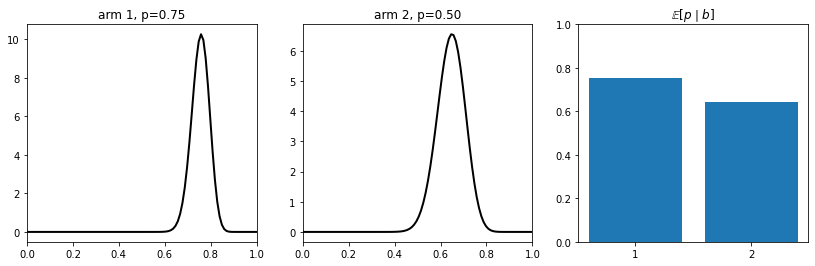

In [5]:
plt.figure(figsize=(14, 4))

x = np.linspace(0, 1, 100)
plt.subplot(1, 3, 1)
a, b = M[0, 0], M[0, 1]
rv = beta(a, b)
plt.plot(x, rv.pdf(x), 'k-', lw=2)
plt.xlim(0,1)
plt.title('arm 1, p=%.2f'%arms[0])
plt.subplot(1, 3, 2)
a, b = M[1, 0], M[1, 1]
rv = beta(a, b)
plt.plot(x, rv.pdf(x), 'k-', lw=2)
plt.xlim(0,1)
plt.title('arm 2, p=%.2f'%arms[1])
plt.subplot(1, 3, 3)
plt.bar([1, 2], [M[0, 0]/np.sum(M[0, :]), M[1, 0]/np.sum(M[1, :])])
plt.xticks([1, 2], [1, 2])
plt.ylim(0,1)
plt.title(r'$\mathbb{E}[p\mid b]$')

In [6]:
M

array([[92, 30],
       [40, 22]])

### Construct belief tree

In [7]:
def get_belief_tree(h, b):

    # initialise the hyperstate tree
    tree = {hi:{} for hi in range(h)}
    
    tree[0][(0)] = b

    for hi in range(1, h):
        c = 0
        for k, v in tree[hi-1].items():
            
            if hi == 1:
                prev_c = 0
            else:
                prev_c = k[-1]
            
            for a in range(2):
                for r in [0, 1]:

                    b1 = belief_update(v, a, r)
                                            
                    tree[hi][(a, prev_c, c)] = b1
                    c += 1
    return tree

### Replay in belief tree

We want to prioritise updates in this belief tree. The prioritisation scheme is the following:

$$
\begin{align*}
v(b')-v(b)=&\sum_a\big[ ( \pi(a\mid b')-\pi(a\mid b) )q(b', a)\big]\\
+&\mathbb{E}_{\pi(a\mid b)}\big[r(b',a) - r(b,a)\big]\\ 
+&\mathbb{E}_{\pi(a\mid b)}\big[\gamma \sum_{g''}p(g''\mid b', a)v(g'') - \gamma \sum_{g'}p(g'\mid b, a)v(g') \big]
\end{align*}
$$

where the policy $\pi(a\mid b)$ is determined by the Gittins index associated with belief $b$, $q(b', a)$ is the Gittins index, and $v(b')=\mathbb{E}_{\pi(a\mid b')}\big[q(b',a)\big]$

For the moment, we will only consider single-step updates from children to their parents

In [8]:
def evb(b, b_prime):

    q = np.array([gittins[b[0, 0], b[0, 1]], gittins[b[1, 0], b[1, 1]]]) # q values before update
    q_prime = np.array([gittins[b_prime[0, 0], b_prime[0, 1]], gittins[b_prime[1, 0], b_prime[1, 1]]]) # q values after update

    probs = policy(q) # policy before update
    probs_prime = policy(q_prime) # policy after update

    gain = np.dot(probs_prime - probs, q_prime) # gain

    tmp_rew = np.array([b[0, 0]/np.sum(b[0, :]), b[1, 0]/np.sum(b[1, :])])
    tmp_rew_prime = np.array([b_prime[0, 0]/np.sum(b_prime[0, :]), b_prime[1, 0]/np.sum(b_prime[1, :])])

    rew = np.dot(probs, (tmp_rew_prime - tmp_rew))

    b_prime_arm0_rew0 = belief_update(b, 0, 0)
    b_prime_arm0_rew1 = belief_update(b, 0, 1)
    b_prime_arm1_rew0 = belief_update(b, 1, 0)
    b_prime_arm1_rew1 = belief_update(b, 1, 1)

    q_prime_arm0_rew0 = np.array([gittins[b_prime_arm0_rew0[0, 0], b_prime_arm0_rew0[0, 1]], gittins[b_prime_arm0_rew0[1, 0], b_prime_arm0_rew0[1, 1]]])
    q_prime_arm0_rew1 = np.array([gittins[b_prime_arm0_rew1[0, 0], b_prime_arm0_rew1[0, 1]], gittins[b_prime_arm0_rew1[1, 0], b_prime_arm0_rew1[1, 1]]])
    q_prime_arm1_rew0 = np.array([gittins[b_prime_arm1_rew0[0, 0], b_prime_arm1_rew0[0, 1]], gittins[b_prime_arm1_rew0[1, 0], b_prime_arm1_rew0[1, 1]]])
    q_prime_arm1_rew1 = np.array([gittins[b_prime_arm1_rew1[0, 0], b_prime_arm1_rew1[0, 1]], gittins[b_prime_arm1_rew1[1, 0], b_prime_arm1_rew1[1, 1]]])

    b_prime_prime_arm0_rew0 = belief_update(b_prime, 0, 0)
    b_prime_prime_arm0_rew1 = belief_update(b_prime, 0, 1)
    b_prime_prime_arm1_rew0 = belief_update(b_prime, 1, 0)
    b_prime_prime_arm1_rew1 = belief_update(b_prime, 1, 1)

    q_prime_prime_arm0_rew0 = np.array([gittins[b_prime_prime_arm0_rew0[0, 0], b_prime_prime_arm0_rew0[0, 1]], gittins[b_prime_prime_arm0_rew0[1, 0], b_prime_prime_arm0_rew0[1, 1]]])
    q_prime_prime_arm0_rew1 = np.array([gittins[b_prime_prime_arm0_rew1[0, 0], b_prime_prime_arm0_rew1[0, 1]], gittins[b_prime_prime_arm0_rew1[1, 0], b_prime_prime_arm0_rew1[1, 1]]])
    q_prime_prime_arm1_rew0 = np.array([gittins[b_prime_prime_arm1_rew0[0, 0], b_prime_prime_arm1_rew0[0, 1]], gittins[b_prime_prime_arm1_rew0[1, 0], b_prime_prime_arm1_rew0[1, 1]]])
    q_prime_prime_arm1_rew1 = np.array([gittins[b_prime_prime_arm1_rew1[0, 0], b_prime_prime_arm1_rew1[0, 1]], gittins[b_prime_prime_arm1_rew1[1, 0], b_prime_prime_arm1_rew1[1, 1]]])

    v_prime_arm0_rew0       = probs[0]*(b[0, 1]/np.sum(b[0, :]))*np.dot(policy(q_prime_arm0_rew0), q_prime_arm0_rew0)
    v_prime_arm0_rew1       = probs[0]*(b[0, 0]/np.sum(b[0, :]))*np.dot(policy(q_prime_arm0_rew1), q_prime_arm0_rew1)
    v_prime_arm1_rew0       = probs[1]*(b[1, 1]/np.sum(b[1, :]))*np.dot(policy(q_prime_arm1_rew1), q_prime_arm1_rew1)
    v_prime_arm1_rew1       = probs[1]*(b[1, 1]/np.sum(b[1, :]))*np.dot(policy(q_prime_arm1_rew0), q_prime_arm1_rew0)

    v_prime_prime_arm0_rew0 = probs[0]*(b_prime[0, 1]/np.sum(b_prime[0, :]))*np.dot(policy(q_prime_prime_arm0_rew0), q_prime_prime_arm0_rew0)
    v_prime_prime_arm0_rew1 = probs[0]*(b_prime[0, 0]/np.sum(b_prime[0, :]))*np.dot(policy(q_prime_prime_arm0_rew1), q_prime_prime_arm0_rew1)
    v_prime_prime_arm1_rew0 = probs[1]*(b_prime[1, 1]/np.sum(b_prime[1, :]))*np.dot(policy(q_prime_prime_arm1_rew0), q_prime_prime_arm1_rew0)
    v_prime_prime_arm1_rew1 = probs[1]*(b_prime[1, 0]/np.sum(b_prime[1, :]))*np.dot(policy(q_prime_prime_arm1_rew1), q_prime_prime_arm1_rew1)

    nxt = gamma*((v_prime_prime_arm0_rew0+v_prime_prime_arm0_rew1+v_prime_prime_arm1_rew0+v_prime_prime_arm1_rew1)-(v_prime_arm0_rew0+v_prime_arm0_rew1+v_prime_arm1_rew0+v_prime_arm1_rew1)) 
    # print(b, b_prime, gain, rew, nxt)
    return gain, rew, nxt

In [9]:
h    = 6
tree = get_belief_tree(h, M)

In [10]:
evb_tree = {hi:{} for hi in range(h)}
for hi in reversed(range(h-1)):
    for k, v in tree[hi].items():
        if hi == 0:
            c = 0
        else:
            c = k[-1]
        for k1, v1 in tree[hi+1].items():
            a = k1[0]
            prev_c = k1[-2]
            if prev_c == c:
                evb_tree[hi][(a, k1[-1])] = [np.sum(evb(v, v1)), v, v1]

### Check updates with the highest evb

In [11]:
updates = {hi:[] for hi in range(h-1)}
for hi in reversed(range(h-1)):
    max_val = 0
    for k, v in evb_tree[hi].items():
        if v[0] > max_val:
            updates[hi] = v
            max_val     = v[0]

In [12]:
updates

{0: [9.256690178422343e-02,
  array([[92, 30],
         [40, 22]]),
  array([[92, 30],
         [41, 22]])],
 1: [0.0964101445437141,
  array([[92, 30],
         [41, 22]]),
  array([[92, 30],
         [42, 22]])],
 2: [0.10018865617013087,
  array([[92, 30],
         [42, 22]]),
  array([[92, 30],
         [43, 22]])],
 3: [0.10388358341011564,
  array([[92, 30],
         [43, 22]]),
  array([[92, 30],
         [44, 22]])],
 4: [0.10750982388367436,
  array([[92, 30],
         [44, 22]]),
  array([[92, 30],
         [45, 22]])]}

### Analyse the evb curve

In [55]:
def gen_plot(arm, param):
    x, y   = 50, 50
    alphas = np.arange(1, x)
    betas  = np.arange(1, y)
    Gain   = np.zeros((x, y))
    Rew    = np.zeros_like(Gain)
    Nxt    = np.zeros_like(Gain)

    for x in alphas:
        for y in betas:
            m = np.array([
                [x, y],
                [10, 10]
            ], dtype=int)
            m_prime = m.copy()
            m_prime[arm, param] += 1
            Gain[x, y], Rew[x, y], Nxt[x, y]  = evb(m, m_prime)
    return Gain, Rew, Nxt

def plot_all(arm, param, title):

    plt.figure(figsize=(16, 4))
    g, r, n = gen_plot(arm, param)
    plt.subplot(1, 4, 1)
    plt.pcolormesh(g[1:, 1:], cmap='Greys')
    plt.colorbar()
    plt.title('Policy gain', fontsize=16)
    plt.ylabel(r'$\alpha$', fontsize=14)
    plt.xlabel(r'$\beta$', fontsize=14)

    plt.subplot(1, 4, 2)
    plt.pcolormesh(r[1:, 1:], cmap='Greys')
    plt.colorbar()
    plt.title('Immediate reward gain', fontsize=16)
    plt.yticks([])
    plt.xlabel(r'$\beta$', fontsize=14)

    plt.subplot(1, 4, 3)
    plt.pcolormesh(n[1:, 1:], cmap='Greys')
    plt.colorbar()
    plt.title('Future reward gain', fontsize=16)
    plt.yticks([])
    plt.xlabel(r'$\beta$', fontsize=14)

    plt.subplot(1, 4, 4)
    plt.pcolormesh((g+r+n)[1:, 1:], cmap='Greys')
    plt.colorbar()
    plt.title('EVB', fontsize=16)
    plt.yticks([])
    plt.xlabel(r'$\beta$', fontsize=14)

    plt.suptitle(title, fontsize=20)
    plt.tight_layout()

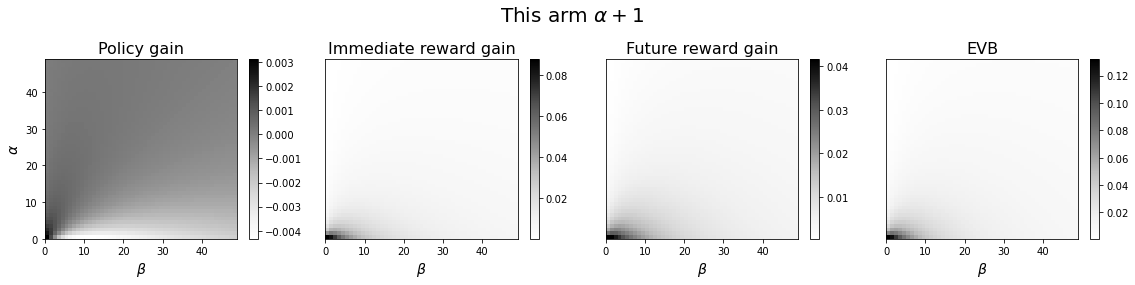

In [56]:
plot_all(0, 0, 'This arm ' + r'$\alpha+1$')

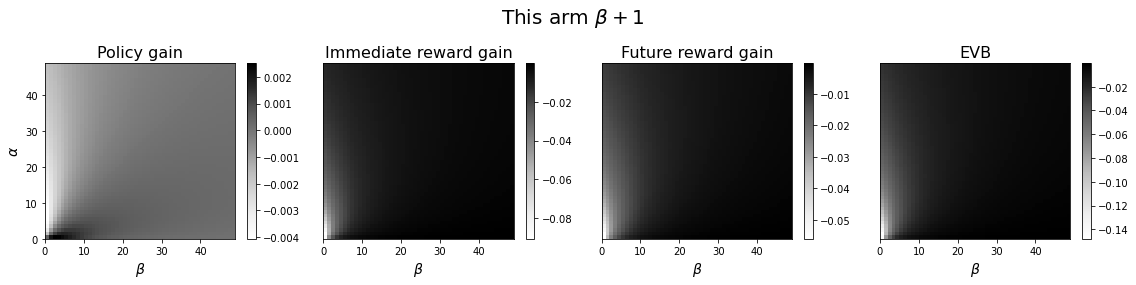

In [48]:
plot_all(0, 1, 'This arm ' + r'$\beta+1$')

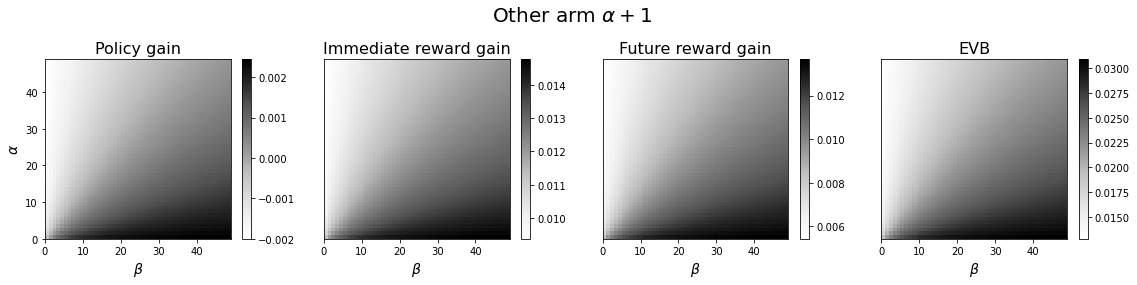

In [49]:
plot_all(1, 0, 'Other arm ' + r'$\alpha+1$')

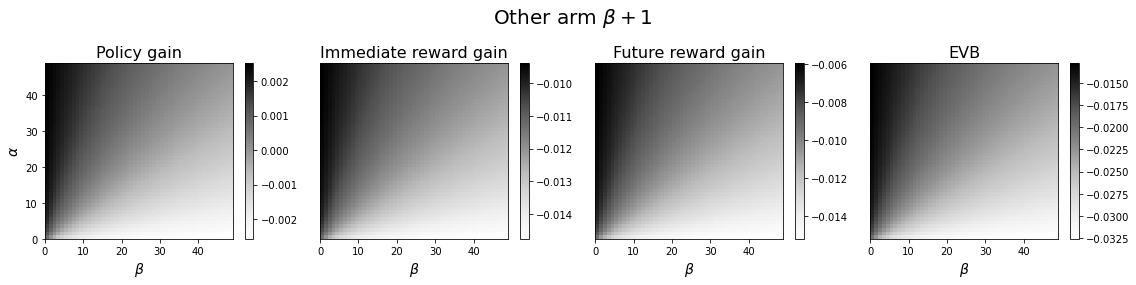

In [50]:
plot_all(1, 1, 'Other arm ' + r'$\beta+1$')